Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [202]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [119]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) price  
    FROM 
        {db}.ldn_listings 
    ORDER BY id 
    LIMIT 1000
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [120]:
q_test.groupby('room_type').quantile(0.75)

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и
рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [122]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) price,
        toFloat32OrNull(review_scores_rating) review_scores_rating
    FROM 
        {db}.ldn_listings 
    WHERE review_scores_rating is not null
    ORDER BY id 
    LIMIT 1000
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [123]:
avg_q = q_test.groupby('room_type').mean()
avg_q

,price,review_scores_rating
room_type,,
Entire home/apt,135.882950,93.568787
Hotel room,134.000000,92.500000
Private room,54.642437,94.766205
Shared room,21.000000,90.000000


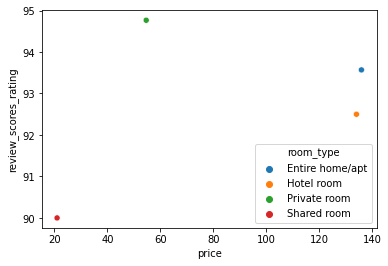

In [124]:
sns.scatterplot(data=avg_q, x="price", y="review_scores_rating", hue=avg_q.index)

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, 
предлагающие различные впечатления (experiences_offered != 'none'). 
Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [126]:
q = '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM 
        ldn_listings 
    WHERE experiences_offered != 'none'
    
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [127]:
q_test['host_ver'] = q_test.host_verifications.apply(lambda x: x.strip('[]').replace('\'', '').split(', '))

In [128]:
q_test

,host_id,host_verifications,host_ver
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off...","[email, phone, facebook, reviews, offline_gove..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm...","[email, phone, jumio, selfie, government_id, i..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ...","[email, phone, manual_offline, jumio, offline_..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm...","[email, phone, reviews, offline_government_id,..."
...,...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin...","[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern...","[email, phone, reviews, jumio, government_id]"
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio...","[email, phone, google, reviews, jumio, offline..."


In [129]:
q_test.explode('host_ver').host_ver.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_ver, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, 
    для одного – family.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, 
поместив в индексы название района, столбцы – вид впечатления, 
а значения – число объявлений с таким впечатлением для каждого района. 
Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

Какой график получился?

In [148]:
q = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        count(experiences_offered) experiences_count
    FROM 
        ldn_listings 
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100 
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [149]:
q_test = q_test.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
q_test

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


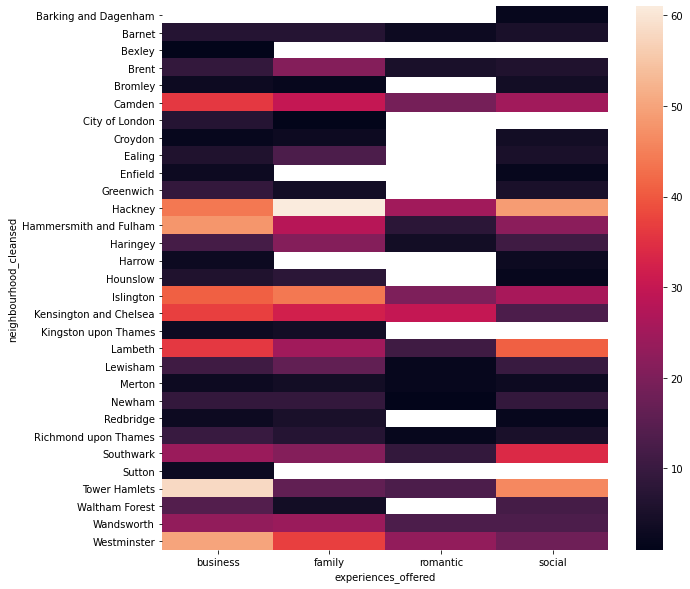

In [161]:
plt.figure(figsize=(10,10))
cmap=sns.cubehelix_palette(as_cmap=True)
sns.heatmap(q_test)

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [163]:
q = '''
    SELECT 
        room_type,
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) price_corr 
    FROM 
        ldn_listings 
    WHERE experiences_offered != 'none'
 
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


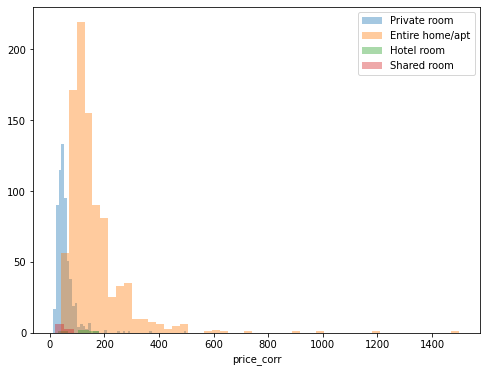

In [190]:
plt.figure(figsize=(8,6))
sns.distplot(q_test.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(q_test.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(q_test.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')
sns.distplot(q_test.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')
plt.legend()
plt.show()

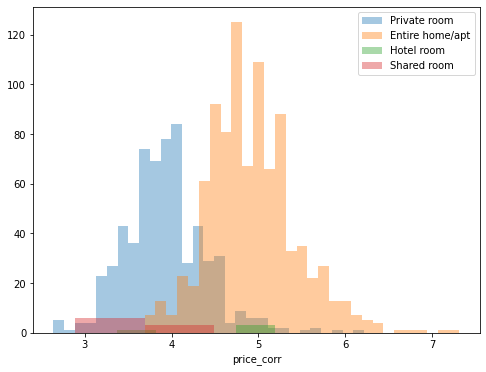

In [194]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(q_test.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(q_test.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_test.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')
sns.distplot(np.log(q_test.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [229]:
q = '''
    SELECT 
        room_type,
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) price_corr,
        first_review
    FROM 
        ldn_listings 
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [230]:
q_test['first_review'] = pd.to_datetime(q_test.first_review)

In [231]:
q_test['first_review'] = q_test.first_review.dt.year

In [232]:
q_test = q_test.rename(columns={'first_review': 'year'}).sort_values('year')

In [233]:
q_test

,room_type,price_corr,year
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


In [234]:
q = q_test.groupby(['room_type', 'year'], as_index=False).agg({'price_corr': 'mean'}) \
    .pivot(index='year', columns='room_type', values='price_corr')
q

room_type,Entire home/apt,Hotel room,Private room,Shared room
year,,,,
2010,103.500000,88.0,56.428571,NaN
2011,128.792453,NaN,52.607143,NaN
2012,135.467249,NaN,53.269841,22.0
2013,137.887640,NaN,57.036585,NaN
2014,154.583333,NaN,56.842105,20.0
2015,159.380952,NaN,48.058824,NaN
2016,99.733333,NaN,57.307692,NaN
2017,111.666667,180.0,51.142857,NaN
2018,125.066667,NaN,55.416667,NaN


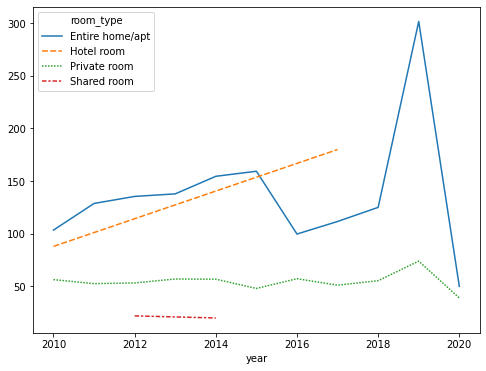

In [235]:
plt.figure(figsize=(8,6))
sns.lineplot(data=q)